<a href="https://colab.research.google.com/github/nicolasmontano/ai-workflow-capstone/blob/master/xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/nicolasmontano/ai-workflow-capstone.git ibm
%cd ibm/scripts/

Cloning into 'ibm'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 51 (delta 30), reused 51 (delta 30), pack-reused 0
Unpacking objects: 100% (51/51), done.
/content/ibm/scripts/ibm/scripts/ibm/scripts


#Packages

In [ ]:
#basics
import pandas as pd
import numpy as np
import math
import re 
import time
import joblib

#OS
from os.path import join

#plots
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
plt.style.use('seaborn')

#data ingestion package
from data_ingestion import fetch_ts, create_lag
#from model_functions import 
#modeling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
#metrics
from sklearn.metrics import mean_squared_error

In [ ]:
data_dir='/content/ibm/data'
df=fetch_ts(data_dir,restart=False)['all']
df=create_lag(df,['revenue','unique_invoices','total_views'],[1,2,3,4,5,6,7,14,28,90,180],['date'],'date')

Reading processeded data from: /content/ibm/data/processed


In [ ]:
df['revenue']=df['revenue'].apply(lambda x: 25000 if x>25000 else x)
df['weekday']=df['date'].apply(lambda x: x.weekday())

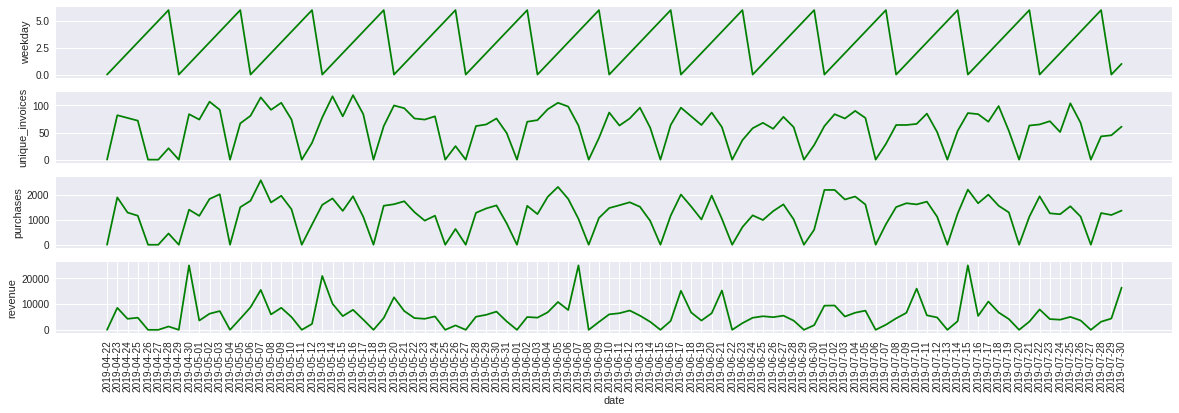

In [ ]:
color='g'
plt.figure(figsize=(20,6))
plt.subplot(411)
sns.lineplot(x='date', y='weekday', data = df[-100:],color=color)
plt.xticks([])
plt.xlabel('')
plt.subplot(412)
sns.lineplot(x='date', y='unique_invoices', data = df[-100:],color=color)
plt.xticks([])
plt.xlabel('')
plt.subplot(413)
sns.lineplot(x='date', y='purchases', data = df[-100:],color=color)
plt.xticks([])
plt.xlabel('')
plt.subplot(414)
sns.lineplot(x='date', y='revenue', data = df[-100:],color=color)
plt.xticks(df[-100:]['date'],rotation=90)
plt.show()

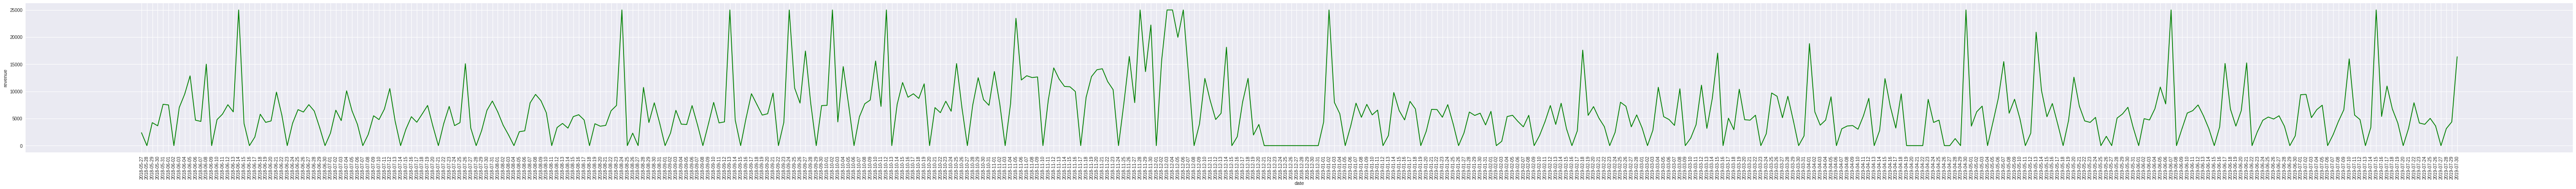

In [ ]:
plt.figure(figsize=(100,6))
sns.lineplot(x='date', y='revenue', data = df,color=color)
plt.xticks(df['date'],rotation=90)
plt.show()

#Train test split


In [ ]:
x_col=[col for col in df.columns if col not in ['date','purchases','unique_invoices','unique_streams','total_views','revenue','months']]
y_col='revenue'

#Train, validation and test creation
train,validation,test=train_val_test_split(df)
X_train,y_train=df_split(train,x_col,y_col)
X_valid,y_valid=df_split(validation,x_col,y_col)
X_test,y_test=df_split(test,x_col,y_col)

train: 339
validation: 61
test: 30


#Preprocessing

In [ ]:
def preprocessing(df,categorical_features):
  numeric_features=[col for col in df.columns.values if col not in categorical_features]

  numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
  categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features)])
  return preprocessor

preprocessor=preprocessing(X_train,['weekday'])

#Random Forest

In [ ]:
def train_rf_regressor(X_train,y_train,X_valid,y_valid,X_test,y_test):
  time_start=time.time()
  
  runtime = "%03d:%02d:%02d"%(h, m, s) 
  n_estimators=[100,200,300,400]
  max_depth=[10,20,30,40]
  min_mse=9999
  model=None
  for estimator in n_estimators:
      for depth in max_depth:
          rf= RandomForestRegressor(n_jobs=-1,max_depth=depth,n_estimators=estimator)
          rf_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor',rf )])
          rf_regressor.fit(X_train,y_train)
          y_val_pred=rf_regressor.predict(X_valid)
          if np.sqrt(mean_squared_error(y_valid,y_val_pred))<min_mse:
            min_mse=np.sqrt(mean_squared_error(y_valid,y_val_pred))
            model=rf_regressor
  y_valid_pred=model.predict(X_valid)  
  y_test_pred=model.predict(X_test)   

  m, s = divmod(time.time()-time_start, 60)
  h, m = divmod(m, 60) 

  print('Training time:{}'.format())     
  print('Validation Error:{}'.format(np.sqrt(mean_squared_error(y_valid,y_val_pred))))
  print('Test Error {}'.format(np.sqrt(mean_squared_error(y_test,y_test_pred))))
  return model

rf_regressor=train_rf_regressor(X_train,y_train,X_valid,y_valid,X_test,y_test)

Validation Error:4658.936048571733
Test Error 4785.559938860981


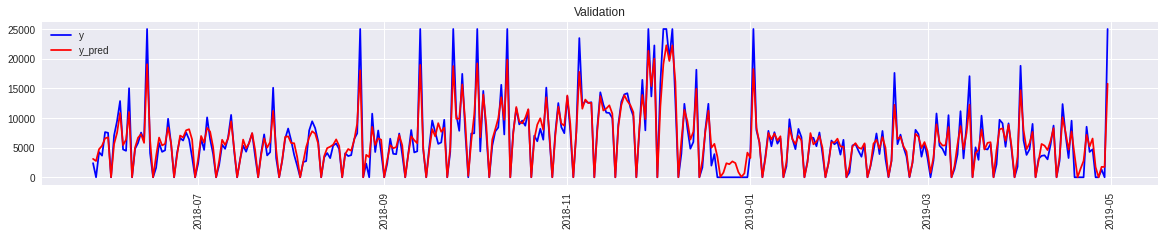

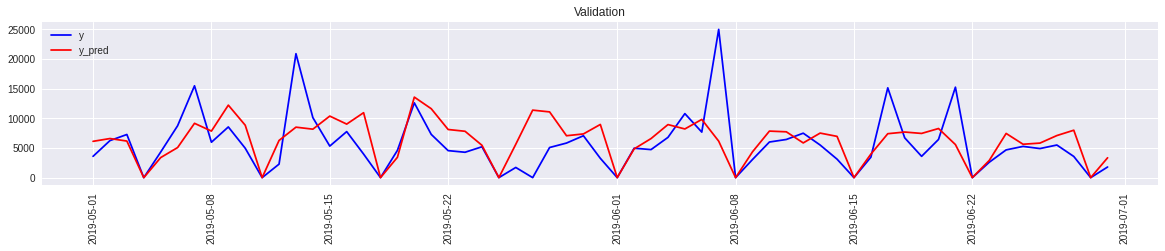

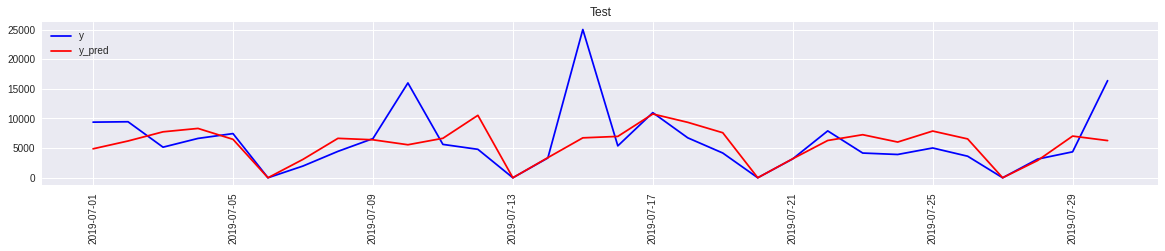

In [ ]:
def plot_results(y,y2,date_series,title,figsize=(20,3)):
  a=pd.DataFrame()
  a['y']=y
  a['y_pred']=y2
  a['date']=date_series
  a.set_index('date',inplace=True)

  plt.figure(figsize=figsize)
  plt.title(title)
  plt.xticks(rotation=90)
  plt.plot(a.iloc[:,0],color='b')
  plt.plot(a.iloc[:,1],color='r')
  plt.legend(['y','y_pred'],loc='upper left')
  plt.show()

plot_results(y_train,rf_regressor.predict(X_train),train['date'],'Train')
plot_results(y_valid,rf_regressor.predict(X_valid),validation['date'],'Validation')
plot_results(y_test,rf_regressor.predict(X_test),test['date'],'Test')

#XGboost

In [ ]:
max_depth=[15,20]
n_estimators=[120,150,200,210]
min_child_weight=[4,5,6]

def train_xgboost_model(X_train,y_train,X_valid,y_valid,X_test,y_test):
  max_depth=[15,20]
  n_estimators=[120,150,200,210]
  min_child_weight=[4,5,6]

  min_score=math.inf
  model_xgb=None
  for depth in max_depth:
    for est in n_estimators:
      for min_child in min_child_weight:
              
        xgb_reg= xgb.XGBRegressor( n_jobs=-1,
                                      num_boost_round=400,
                                      max_depth=depth,
                                      min_child_weigh=min_child,
                                      n_estimators=est,
                                      learning_rate=0.01,
                                      early_stopping_rounds=5)
        xgb_regressor = Pipeline(steps=[('preprocessor', preprocessor),('model',xgb_reg )])
        xgb_regressor.fit(X_train,y_train)
        score=mean_squared_error(xgb_regressor.predict(X_valid),y_valid)
        if score<min_score:
          min_score=score
          model_xgb=xgb_regressor

  y_val_pred=model_xgb.predict(X_valid)
  y_test_pred=model_xgb.predict(X_test)
  print('Validation Error:{}'.format(np.sqrt(mean_squared_error(y_valid,y_val_pred))))
  print('Test Error {}'.format(np.sqrt(mean_squared_error(y_test,y_test_pred))))

  return model_xgb

model_xgb=train_xgboost_model(X_train,y_train,X_valid,y_valid,X_test,y_test)

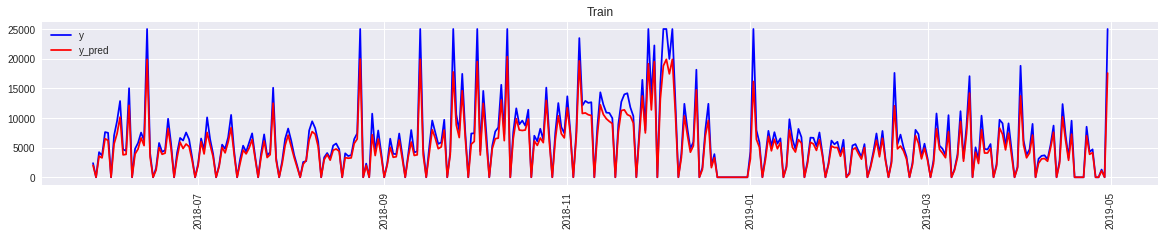

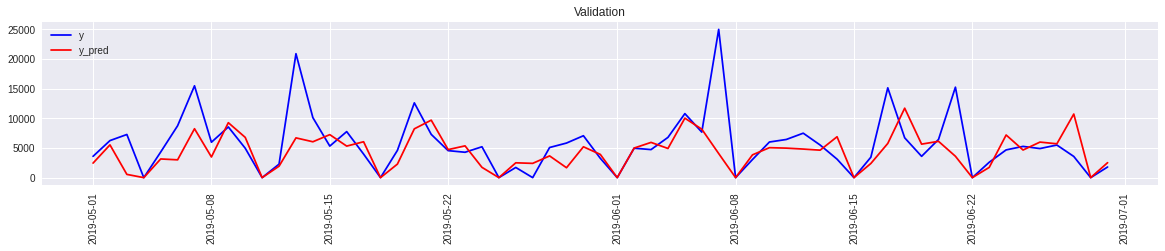

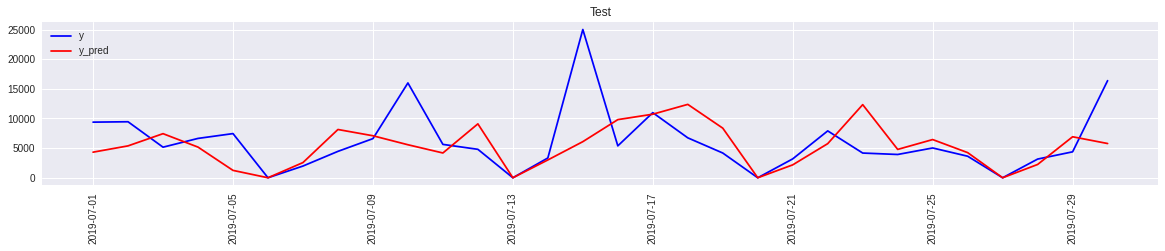

In [ ]:
plot_results(y_train,model_xgb.predict(X_train),train['date'],'Train')
plot_results(y_valid,model_xgb.predict(X_valid),validation['date'],'Validation')
plot_results(y_test,model_xgb.predict(X_test),test['date'],'Test')

In [ ]:
X_train_2=pd.concat([X_train,X_valid],axis=0)
y_train_2=pd.concat([y_train,y_valid])
split_index = [-1 if x in X_train.index else 0 for x in X_train_2.index]
pds = PredefinedSplit(test_fold = split_index)

X_train_2.reset_index(inplace=True,drop=True)
y_train_2.reset_index(inplace=True, drop=True)


split_index = [-1 if x in X_train.index else 0 for x in X_train_2.index]
pds = PredefinedSplit(test_fold = split_index)

xgb_reg= xgb.XGBRegressor( n_jobs=-1,
                              num_boost_round=400,
                              max_depth=100,
                              min_child_weigh=5,
                              n_estimators=200,
                              learning_rate=0.01,
                              early_stopping_rounds=5)
xgb_regressor = Pipeline(steps=[('preprocessor', preprocessor),
              ('model',xgb_reg )])


In [ ]:
param_grid={
            'model__max_depth': [15,20],
            'model__n_estimators': [120,150,200,210],
            'model__min_child_weight':[4,5,6]
            }
xgb_regressor_cv= GridSearchCV(xgb_regressor,param_grid=param_grid,cv=pds,verbose=0,scoring='neg_mean_squared_error',n_jobs=-1)
xgb_regressor_cv.fit(X_train_2,y_train_2)
model_xgb=xgb_regressor_cv.best_estimator_

[05:58:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


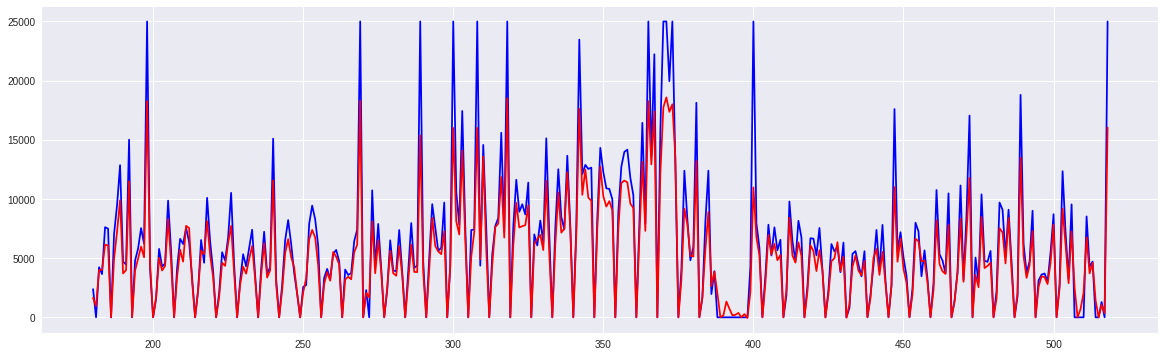

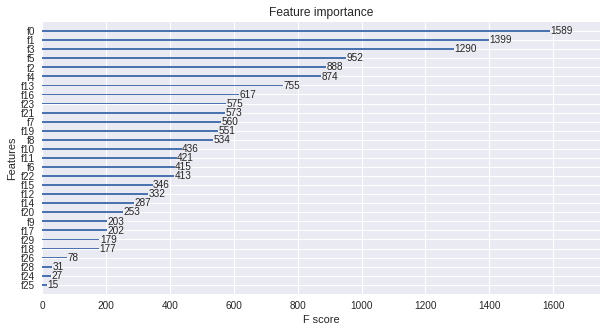

In [ ]:
xgb.plot_importance(a[1])
plt.rcParams['figure.figsize'] = [5, 20]
plt.show()

#SAVE MODELS

In [ ]:
## retrain using all data
MODEL_VERSION=1.1
MODEL_DIR='/content/ibm/models'

def save_model(MODEL_DIR,MODEL_VERSION,name,model):
  saved_model=join(MODEL_DIR,'{}_{}.joblib'.format(name,MODEL_VERSION))
  joblib.dump(model,saved_model)

#LOAD MODELS

In [ ]:
MODEL_DIR='/content/ibm/models'
def load_model(MODEL_DIR,name):

  try:
    return joblib.load(join(MODEL_DIR,name))
  except:
    print('{} not found in {}'.format(name,MODEL_DIR))
  

m1=load_model(MODEL_DIR,'rf_1.1.joblib')

In [ ]:

model_name = re.sub("\.","_",str(MODEL_VERSION))

if test:
    saved_model = os.path.join(MODEL_DIR,
                                "test-{}-{}.joblib".format(tag,model_name))
    print("... saving test version of model: {}".format(saved_model))
else:
    saved_model = os.path.join(MODEL_DIR,
                                "sl-{}-{}.joblib".format(tag,model_name))
    print("... saving model: {}".format(saved_model))
    
joblib.dump(grid,saved_model)

m, s = divmod(time.time()-time_start, 60)
h, m = divmod(m, 60)
runtime = "%03d:%02d:%02d"%(h, m, s) 

In [ ]:
time_start=time.time()
m, s = divmod(time.time()-time_start, 60)
h, m = divmod(m, 60)
runtime = "%03d:%02d:%02d"%(h, m, s) 

In [ ]:
model_name='xgb'
MODEL_VERSION=1.1
MODEL_DIR='/content/ibm/models'
join(MODEL_DIR,"{}-{}.joblib".format(model_name,MODEL_VERSION))


'/content/ibm/models/xgb-1.1.joblib'

In [ ]:
joblib.dump(model,'xgboost.joblib')

['xgboost.joblib']

In [ ]:
!ls

data_ingestion.py  model.py


In [ ]:
!pwd

/content/ibm/scripts/ibm/scripts/ibm/scripts


In [ ]:
!mkdir /content/ibm/models